## Load Packages

We process our data using `numpy` and `pandas`. We use `geopandas` for visualizing geographical data.

In [2]:
# for automatic reloading of modules (quick debugging)
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append('..') # add parent directory to path

import numpy as np 
import pandas as pd
from utils import processing as pr
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns

### Load and Process Data
Loading two years and three months worth of data (explained in more detail in `00_a_data_summary.ipynb`)

In [3]:
# preprocess months and years to an (N,2)-array
months = np.arange(1,12+1,1)
years = np.arange(2022,2023+1,1)
month_year = np.meshgrid(years, months)
month_year = np.array(month_year).T.reshape(-1,2)

# add first three months of 2024
month_year = np.vstack([month_year, [2024,1], [2024,2], [2024,3]])

# indicate desired taxi zones
zdf = pd.read_csv('../assets/taxi_zone_lookup.csv')
zdf = zdf[(zdf['Borough'] == 'Manhattan') & (~zdf['LocationID'].isin([103, 104, 105, 153, 194, 202]))]
taxi_zones = list(zdf['LocationID'].values)

In [4]:
# generate time series data
ts = pr.generate_processed_data(month_year, vehicle_type='yellow', by_value=['PULocationID'], additional_features=True, taxi_zones=taxi_zones)
ts

  0%|          | 0/27 [00:00<?, ?it/s]

100%|██████████| 27/27 [02:27<00:00,  5.46s/it]


,PULocationID,pickup_datetime,counts,total_amount,tip_amount,fare_amount,trip_distance,passenger_count,trip_duration
0,4,2022-01-01 00:00:00-05:00,8,18.896250,1.533750,13.562500,3.363750,1.375000,14.481250
1,12,2022-01-01 00:00:00-05:00,1,29.750000,4.950000,21.000000,5.600000,4.000000,22.650000
2,13,2022-01-01 00:00:00-05:00,10,22.111000,2.461000,15.850000,4.386000,1.300000,14.801666
3,24,2022-01-01 00:00:00-05:00,10,15.101000,1.501000,10.500000,2.242000,1.200000,11.380000
4,41,2022-01-01 00:00:00-05:00,9,17.226665,1.260000,12.722222,3.082222,1.777778,13.890740
...,...,...,...,...,...,...,...,...,...
1236496,246,2024-03-31 23:00:00-04:00,26,17.835384,2.081538,10.753846,1.755385,1.653846,8.076283
1236497,249,2024-03-31 23:00:00-04:00,56,19.856070,2.743572,12.112500,2.020179,1.446429,9.940179
1236498,261,2024-03-31 23:00:00-04:00,2,13.910000,1.360000,7.550000,0.690000,1.000000,5.641666
1236499,262,2024-03-31 23:00:00-04:00,5,15.820000,0.400000,10.420000,1.858000,1.400000,6.876666


### Postprocessing

In [5]:
ts_p = pr.postprocess_data(ts, by_value=['PULocationID'])

### Save Taxi Dataframe and Geopandas Dataframe

This is the dataset we use to train various models. It is saved outside the repo. We also save a dataset of the specific taxi zones that we are using for future convenience.

In [6]:
os.system('mkdir -p ../../processed_taxi_data')

# save processed taxi dataframe
ts_p.to_pickle('../../processed_taxi_data/adjusted_yellow_2022-01_2024-03_bypulocation.pkl')

In [7]:
# Geopandas dataframe
gdf = gpd.read_file('../assets/tableau/taxi_zones/taxi_zones.shp')  # read shapefile
gdf = gdf[(gdf['borough'] == 'Manhattan') & (~gdf['LocationID'].isin([103, 104, 105, 153, 194, 202]))]

# extract coordinates of zones: https://gis.stackexchange.com/questions/412817/how-to-get-lat-and-lon-from-a-geopandas-geodataframe-polygon
gdf = gdf.to_crs(4326) # reproject data
gdf['lon'] = gdf.centroid.x  
gdf['lat'] = gdf.centroid.y
gdf.reset_index(drop=True, inplace=True)

# save geopandas dataframe
gdf.to_pickle('../../processed_taxi_data/manhattan_taxi_zones.pkl')

/tmp/ipykernel_2358/3470049900.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/tmp/ipykernel_2358/3470049900.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y


## Sample Data Visualization
Cells taken directly from `00_data_summary.ipynb`.

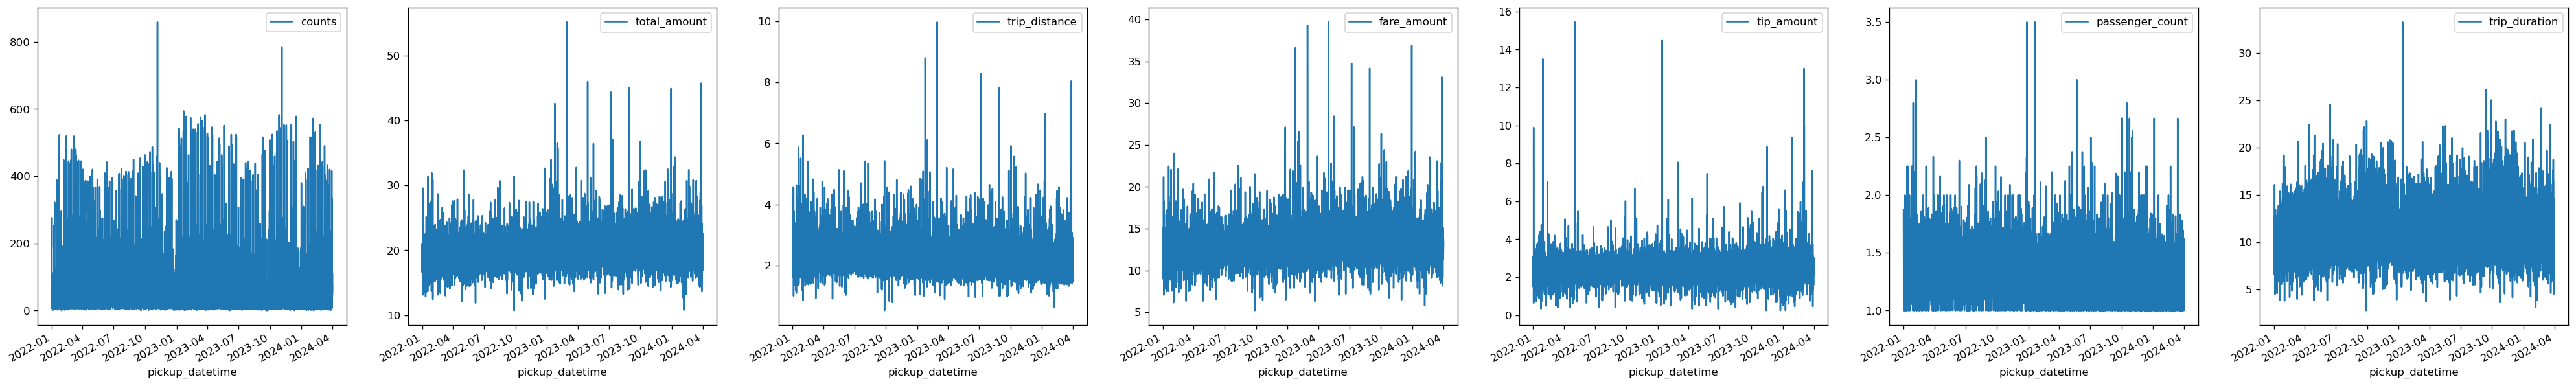

In [8]:
# time series data for zone 79
ts_z = ts_p[ts_p['PULocationID'] == 79].copy() # equivalent for route-level data: ts_z = pr.route_to_pulocation(ts, 4)
fig, axes = plt.subplots(figsize = (6*7, 6), dpi = 120, nrows = 1, ncols = 7)
for i, col in enumerate(['counts', 'total_amount', 'trip_distance', 'fare_amount', 'tip_amount', 'passenger_count', 'trip_duration']):
    ts_z.plot(x = 'pickup_datetime', y = col, ax = axes[i])

/tmp/ipykernel_2358/802093817.py:4: RuntimeWarning: divide by zero encountered in log10
  ts_z['log_' + f] = np.log10(ts_z[f].values)


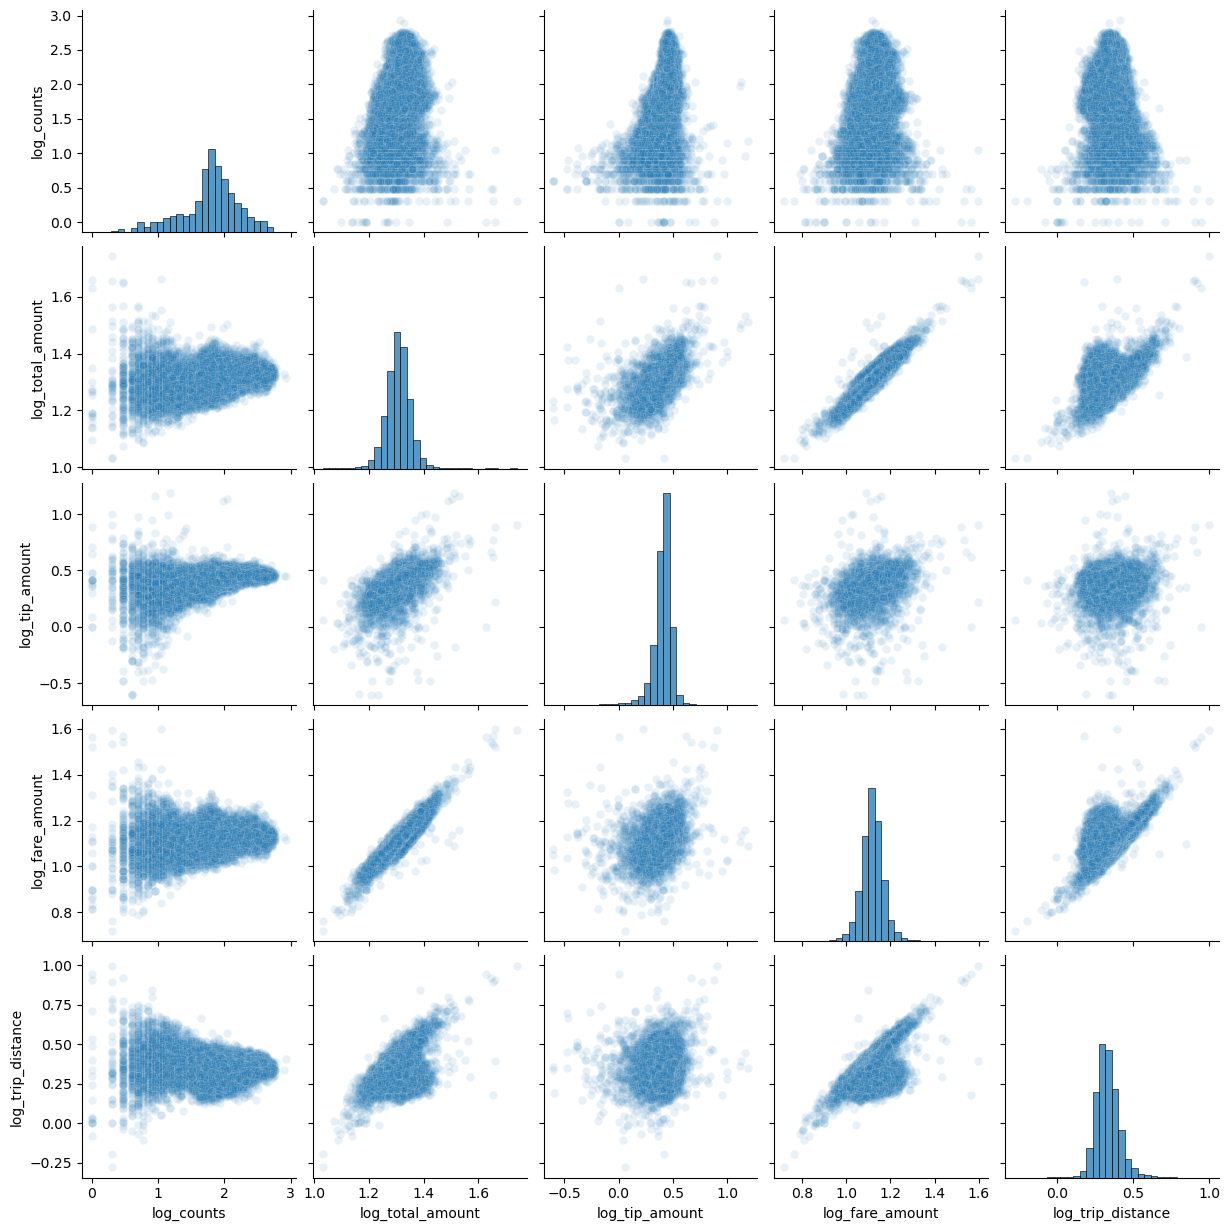

In [9]:
# time series data for zone 79 
features = ['counts', 'total_amount', 'tip_amount', 'fare_amount', 'trip_distance']
for f in features:
    ts_z['log_' + f] = np.log10(ts_z[f].values)
log_features = ['log_' + f for f in features]
sns.pairplot(ts_z[log_features], diag_kws = {'bins': 30}, plot_kws = {'alpha': 0.1})

/tmp/ipykernel_2358/3444229871.py:4: RuntimeWarning: divide by zero encountered in log10
  ts_p['log_' + f] = np.log10(ts_p[f].values)


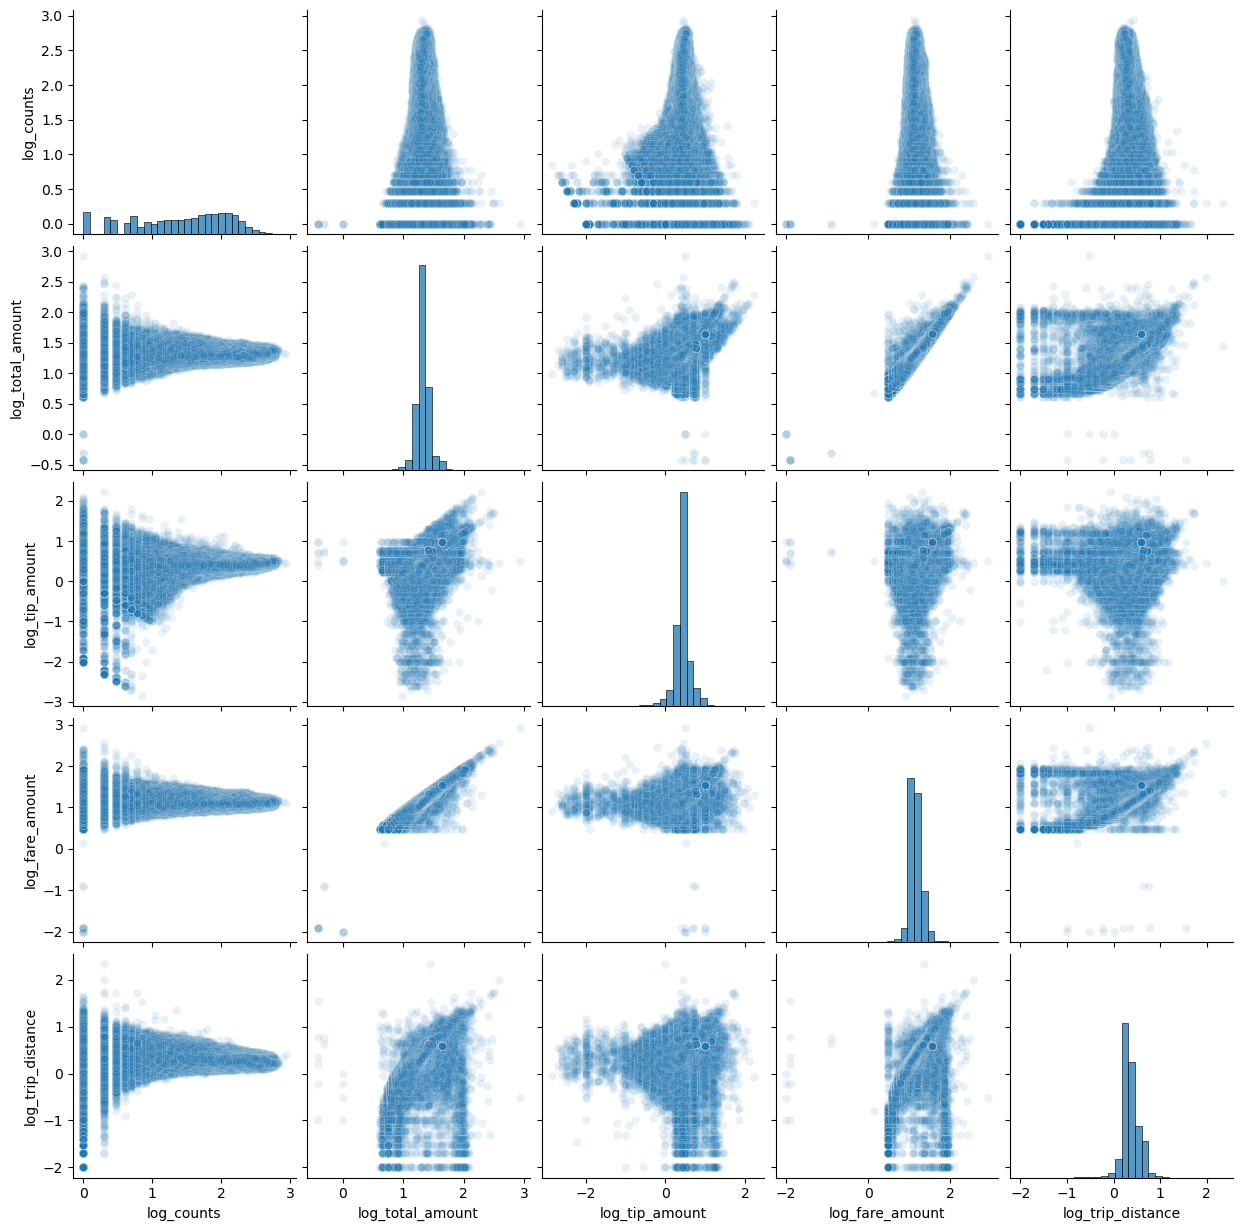

In [10]:
# time series data for all zones
features = ['counts', 'total_amount', 'tip_amount', 'fare_amount', 'trip_distance']
for f in features:
    ts_p['log_' + f] = np.log10(ts_p[f].values)
log_features = ['log_' + f for f in features]
sns.pairplot(ts_p[log_features], diag_kws = {'bins': 30}, plot_kws = {'alpha': 0.1})